# Notebook error analysis 

## Manual labels of the sampled errors

in terms of bug types and root causes

Filter out / exclude:

    ML_pipeline == non-applicable/unknown
    Other==self-raised/should exclude/intentional

In [1]:
# import importlib
# importlib.reload(config)
# import config

In [1]:
import pandas as pd
import config

# # config
# df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config.xlsx'),
#                                 keep_default_na=False)
# # data
# df_mlerr_labels_g = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_g.xlsx'))
# df_mlerr_labels_k = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_k.xlsx'))

# summed config
# config
df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config_sum.xlsx'),
                                keep_default_na=False)
# data
df_mlerr_labels_g_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_g_sum.xlsx'))
df_mlerr_labels_k_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_k_sum.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
exclude_config = ["label_if_error_chain"] # because it is the same as root cause==nb specific-previous cell error
df_mlerr_label_config_sum.drop(exclude_config, axis=1, inplace=True)

In [3]:
# before filtering
# print(df_mlerr_labels_g.eid.nunique())
# print(df_mlerr_labels_k.eid.nunique())
print(df_mlerr_labels_g_sum.eid.nunique())
print(df_mlerr_labels_k_sum.eid.nunique())

390
356


In [4]:
# exclude_ml_pipeline = ['not-applicable (sub-labels needed, e.g., tutorials, physics simulation, ..)',
#                        'not applicable - tutorial notebook',
#                        'not applicable - physics',
#                        'not applicable - education',
#                        'unknown']
exclude_other = ['intentional', 'should exclude']
exclude_ml_pipeline_sum = ['not applicable','unknown']
# df_mlerr_labels_g = df_mlerr_labels_g[(~df_mlerr_labels_g.label_ML_pipeline.isin(exclude_ml_pipeline))&(~df_mlerr_labels_g.other.isin(exclude_other))]
# df_mlerr_labels_k = df_mlerr_labels_k[(~df_mlerr_labels_k.label_ML_pipeline.isin(exclude_ml_pipeline))&(~df_mlerr_labels_k.other.isin(exclude_other))]
df_mlerr_labels_g_sum = df_mlerr_labels_g_sum[(~df_mlerr_labels_g_sum.label_ML_pipeline.isin(exclude_ml_pipeline_sum))&(~df_mlerr_labels_g_sum.other.isin(exclude_other))]
df_mlerr_labels_k_sum = df_mlerr_labels_k_sum[(~df_mlerr_labels_k_sum.label_ML_pipeline.isin(exclude_ml_pipeline_sum))&(~df_mlerr_labels_k_sum.other.isin(exclude_other))]

In [5]:
# after filtering
# print(df_mlerr_labels_g.eid.nunique())
# print(df_mlerr_labels_k.eid.nunique())
print(df_mlerr_labels_g_sum.eid.nunique())
print(df_mlerr_labels_k_sum.eid.nunique())

291
321


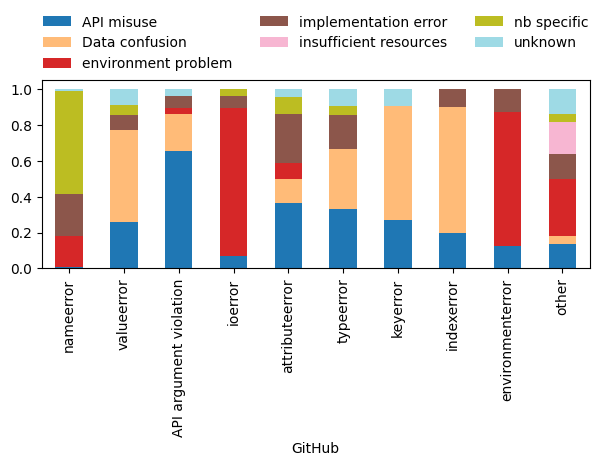

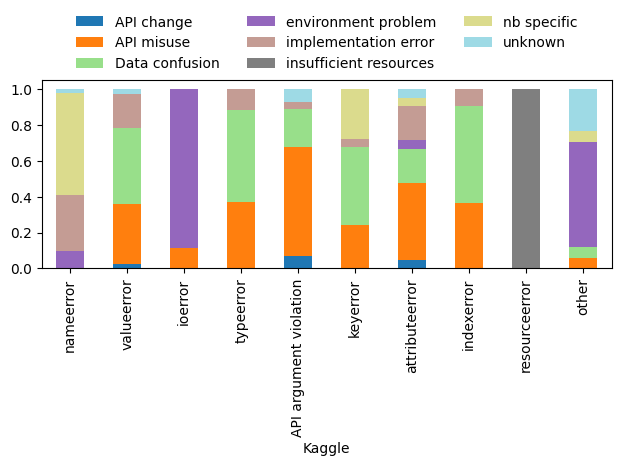

In [49]:
import matplotlib.pyplot as plt

def plot_relationship_stackedbar(x_var, y_var, df, source="Kaggle",include_num=9):
    x_var, y_var = "label_refined_exp_type", "label_root_cause"
    df_grouped = df.groupby(x_var)[y_var].value_counts().unstack(y_var)
    df_grouped_index_sorted = df[x_var].value_counts().sort_values(ascending=False).index
    df_grouped = df_grouped.reindex(df_grouped_index_sorted)
    df_other = pd.DataFrame(df_grouped[include_num:].sum(axis=0)).T.rename(index={0: "other"})
    df_grouped = pd.concat([df_grouped[:include_num], df_other])
    df_grouped = (df_grouped.T/df_grouped.sum(axis=1)).T
    df_grouped.plot.bar(stacked=True, colormap='tab20')
    plt.legend(
        bbox_to_anchor=(0.5, 1.02),
        loc="lower center",
        borderaxespad=0,
        frameon=False,
        ncol=3,
    )
    plt.xlabel(source)
    plt.tight_layout()
    plt.show()
    
plot_relationship_stackedbar("label_refined_exp_type", "label_root_cause", df_mlerr_labels_g_sum, "GitHub")
plot_relationship_stackedbar("label_refined_exp_type", "label_root_cause", df_mlerr_labels_k_sum, "Kaggle")

Summarize the statistics and plot overview of total numbers per category for each dimension

In [7]:
# summarize the statistics
def statistics_labels(df_mlerr_label_config, df_mlerr_labels):
    cluster_res = {}
    for label_key in df_mlerr_label_config:
        cluster_res[label_key] = {}

    df_mlerr_labeled_clusters = df_mlerr_labels.cluster_id.unique()
    for cluster_id in df_mlerr_labeled_clusters:
        cluster_errors = df_mlerr_labels[df_mlerr_labels.cluster_id == cluster_id]
        for label_key in df_mlerr_label_config:
            for label_key_option in df_mlerr_label_config[label_key].dropna():
                cluster_label_key_option_size = sum(cluster_errors[label_key]==label_key_option)
                if label_key_option not in cluster_res[label_key]:
                    cluster_res[label_key][label_key_option] = {}
                cluster_res[label_key][label_key_option][cluster_id] = (cluster_label_key_option_size, len(cluster_errors))
    return cluster_res

In [8]:
import math

def map_element_weights(x):
    if isinstance(x, tuple):
        return x[0]
    else:
        return x

# calculated/summed over all clusters, sorted
def cal_weighted_sum(df_mlerr_label_config, cluster_res):
    cluster_res_weighted_sum = {}
    for label_key in df_mlerr_label_config:
        cluster_res_weight = cluster_res[label_key].map(map_element_weights)
        tmp = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
        cluster_res_weighted_sum[label_key] = {k: v for k, v in tmp.items() if k}
    return cluster_res_weighted_sum

In [9]:
# github stats
cluster_res_g_sum = statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_g_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_g_sum[label_key] = pd.DataFrame.from_dict(cluster_res_g_sum[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_sum_weighted_sum = cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_g_sum)

# kaggle stats
cluster_res_k_sum = statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_k_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_k_sum[label_key] = pd.DataFrame.from_dict(cluster_res_k_sum[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_sum_weighted_sum = cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_k_sum)

In [10]:
rc = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_root_cause'],
                   cluster_res_g_sum_weighted_sum['label_root_cause']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
rc['Kaggle']=(rc['Kaggle']/rc['Kaggle'].sum()).round(2)
rc['GitHub']=(rc['GitHub']/rc['GitHub'].sum()).round(2)
rc

,Kaggle,GitHub
API misuse,0.21,0.19
Data confusion,0.20,0.17
nb specific,0.20,0.23
environment problem,0.16,0.20
implementation error,0.15,0.16
insufficient resources,0.03,0.01
unknown,0.03,0.04
API change,0.01,0.00


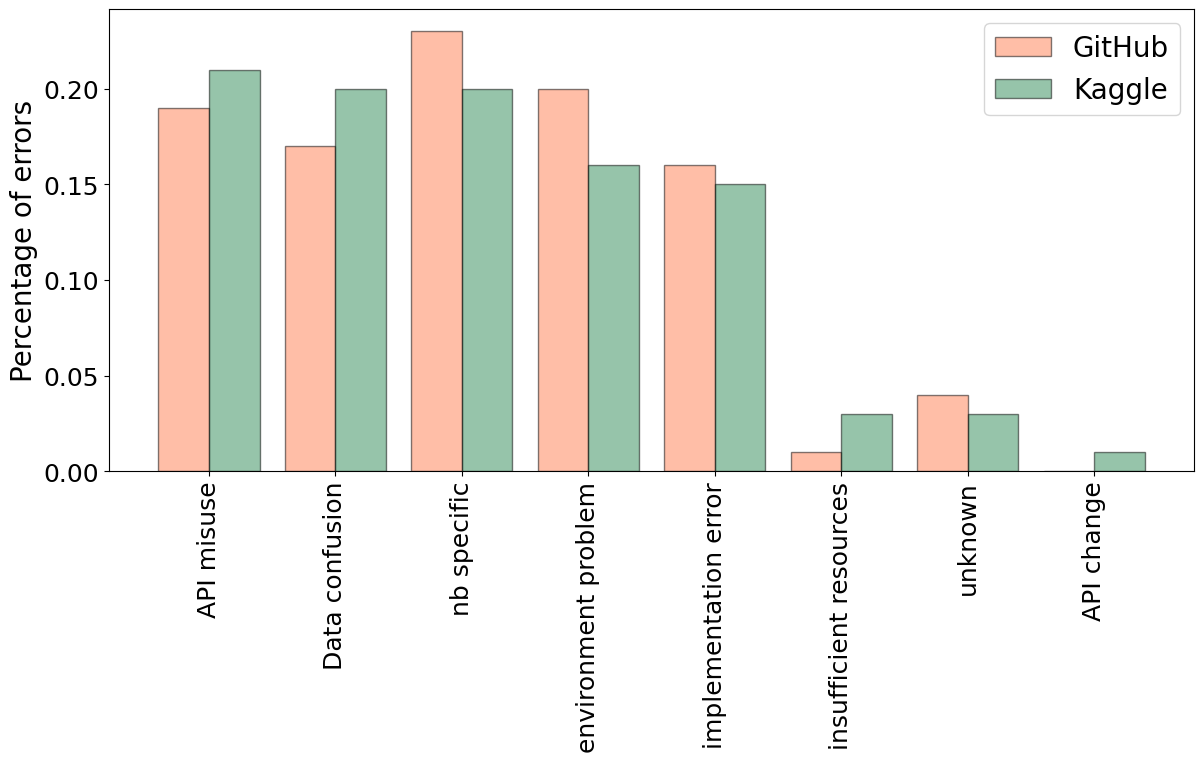

In [18]:
ind = np.arange(len(rc.index))

width = 0.4
fontsize = 20
plt.figure(figsize=(14,6))
plt.bar(ind - width / 2, rc.GitHub, width, label = 'GitHub', alpha = 0.5, color = 'coral', edgecolor = 'black') 
plt.bar(ind + width / 2, rc.Kaggle, width, label = 'Kaggle', alpha = 0.5, color = 'seagreen', edgecolor = 'black') 
  
plt.xticks(ind, rc.index, rotation=90, fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
# plt.xlabel("Exception types", fontsize=fontsize) 
plt.ylabel("Percentage of errors", fontsize=fontsize) 
plt.legend(fontsize=fontsize) 
plt.savefig(r"C:\Users\yirwa29\OneDrive - Linköpings universitet\SAProject\Paper2/ml_root cause.pdf", bbox_inches='tight')
plt.show()

In [11]:
bt = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_refined_exp_type'],
                   cluster_res_g_sum_weighted_sum['label_refined_exp_type']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
bt['Kaggle']=(bt['Kaggle']/bt['Kaggle'].sum()).round(2)
bt['GitHub']=(bt['GitHub']/bt['GitHub'].sum()).round(2)
bt

,Kaggle,GitHub
nameerror,0.30,0.36
valueerror,0.13,0.12
ioerror,0.11,0.10
typeerror,0.11,0.07
API argument violation,0.09,0.10
keyerror,0.08,0.04
attributeerror,0.07,0.08
resourceerror,0.03,0.01
indexerror,0.03,0.03
environmenterror,0.02,0.03


In [14]:
mlbug = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_if_ML_bug'],
                   cluster_res_g_sum_weighted_sum['label_if_ML_bug']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlbug['Kaggle']=(mlbug['Kaggle']/mlbug['Kaggle'].sum()).round(2)
mlbug['GitHub']=(mlbug['GitHub']/mlbug['GitHub'].sum()).round(2)
mlbug[:2]

,Kaggle,GitHub
ML bug,0.73,0.63
python bug,0.27,0.37


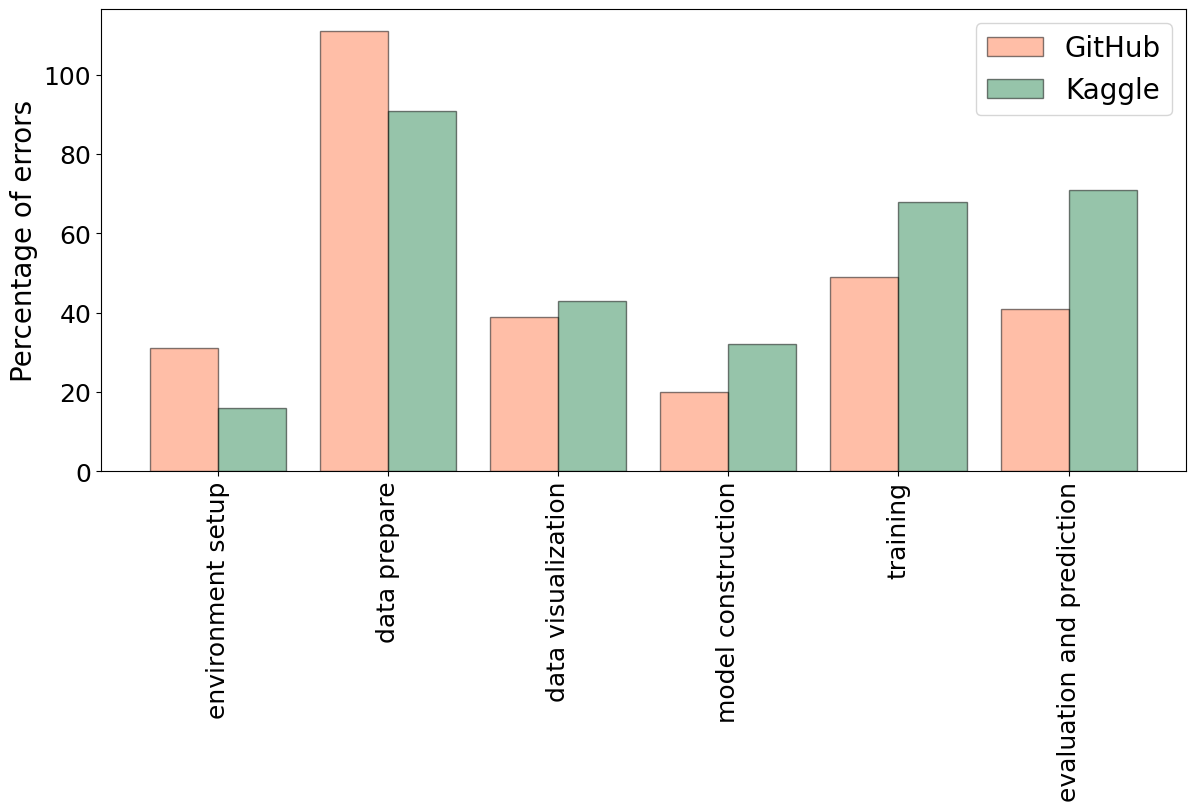

,Kaggle,GitHub
environment setup,16,31
data prepare,91,111
data visualization,43,39
model construction,32,20
training,68,49
evaluation and prediction,71,41


In [16]:
import numpy as np

mlpp = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_ML_pipeline'],
                     cluster_res_g_sum_weighted_sum['label_ML_pipeline']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
# mlpp['Kaggle']=(mlpp['Kaggle']/mlpp['Kaggle'].sum()).round(2)
# mlpp['GitHub']=(mlpp['GitHub']/mlpp['GitHub'].sum()).round(2)
mlpp = mlpp.reindex(["environment setup", "data prepare", "data visualization", "model construction", "training", "evaluation and prediction"])

ind = np.arange(len(mlpp.index))

width = 0.4
fontsize = 20
plt.figure(figsize=(14,6))
plt.bar(ind - width / 2, mlpp.GitHub, width, label = 'GitHub', alpha = 0.5, color = 'coral', edgecolor = 'black') 
plt.bar(ind + width / 2, mlpp.Kaggle, width, label = 'Kaggle', alpha = 0.5, color = 'seagreen', edgecolor = 'black') 
  
plt.xticks(ind, mlpp.index, rotation=90, fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
# plt.xlabel("Exception types", fontsize=fontsize) 
plt.ylabel("Percentage of errors", fontsize=fontsize) 
plt.legend(fontsize=fontsize) 
plt.savefig(r"C:\Users\yirwa29\OneDrive - Linköpings universitet\SAProject\Paper2/ml_pipeline.pdf", bbox_inches='tight')
plt.show()

mlpp

## Chi-square test

An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5.

    p-value<0.05 -> reject the null hypothesis (there s no difference between the two distributions)-> the two dist are statistically different
    p-value>0.05 -> cannot reject the null, not different

[scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

[Chi-squared_test](https://en.wikipedia.org/wiki/Chi-squared_test)

[color map](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

label_root_cause 2
Chi2ContingencyResult: pvalue is  0.995350549903933 (Not statistically different)


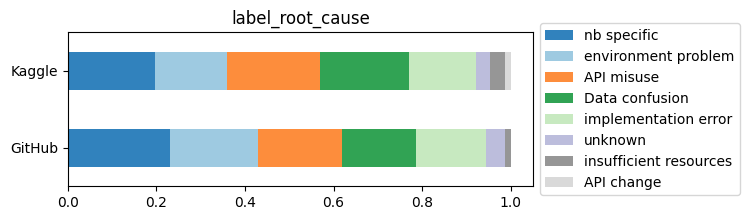

label_ML_pipeline 2
Chi2ContingencyResult: pvalue is  0.03596999308750023 (Statistically different)


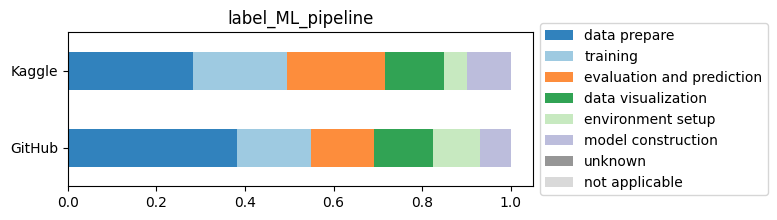

label_if_ML_bug 1
Chi2ContingencyResult: pvalue is  0.008555990412985853 (Statistically different)


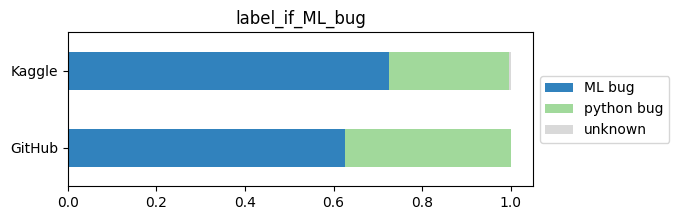

label_refined_exp_type 5
Chi2ContingencyResult: pvalue is  0.8513610498818229 (Not statistically different)


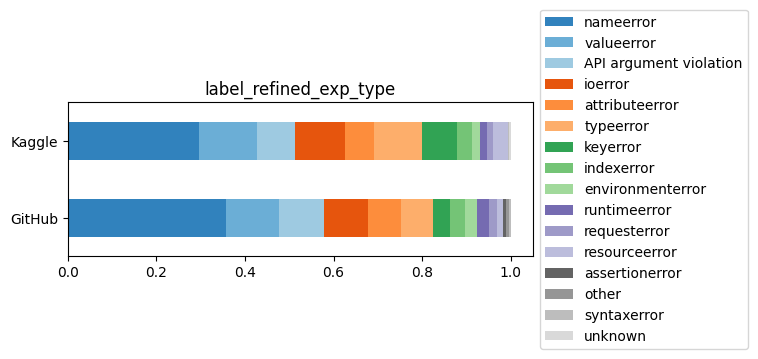

label_if_runinfo_help 0
Chi2ContingencyResult: pvalue is  0.02065055090540317 (Statistically different)


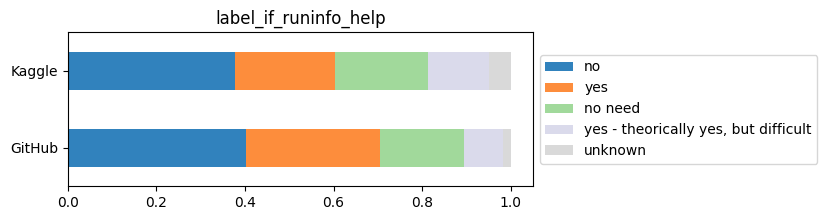

label_if_code_error_align 1
Chi2ContingencyResult: pvalue is  0.9271097582075327 (Not statistically different)


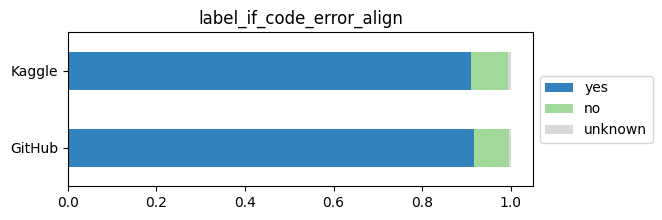

label_if_error_chain 0
Chi2ContingencyResult: pvalue is  0.07268841126117276 (Not statistically different)


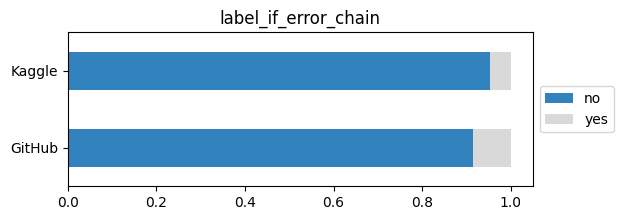

other 4
Chi2ContingencyResult: pvalue is  1.0 (Not statistically different)


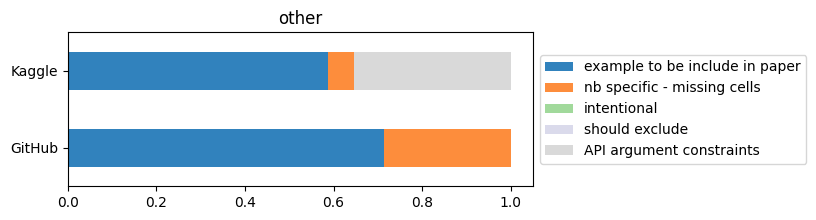

In [17]:
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# plot stacked bar chart to compare GitHub and Kaggle over each categories
for label_key in df_mlerr_label_config_sum:
    bar_label_key_gk = pd.DataFrame({"GitHub": cluster_res_g_sum_weighted_sum[label_key],
                                     "Kaggle": cluster_res_k_sum_weighted_sum[label_key]})
    bar_label_key_gk = bar_label_key_gk.div(bar_label_key_gk.sum(axis=0), axis=1)

    table_label_key_gk = np.array(([v for k, v in cluster_res_k_sum_weighted_sum[label_key].items()],
                                   [v for k, v in cluster_res_g_sum_weighted_sum[label_key].items()])).T
    table_label_key_gk = np.delete(table_label_key_gk, np.where(table_label_key_gk < 5)[0], axis=0)
    print(label_key,len(cluster_res_k_sum_weighted_sum[label_key])-table_label_key_gk.shape[0])
    pvalue_chisquare = chi2_contingency(table_label_key_gk).pvalue
    print("Chi2ContingencyResult: pvalue is ", pvalue_chisquare, 
          "(Not statistically different)" if pvalue_chisquare > 0.05 else "(Statistically different)")
    
    # plot
    bar_label_key_gk.T.plot(kind="barh", stacked=True, figsize=(6,2), colormap='tab20c')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(label_key)
    plt.show()